In [1]:
from commonfunctions import *
from ColorHarmonization import *
from enum import Enum
%matplotlib inline


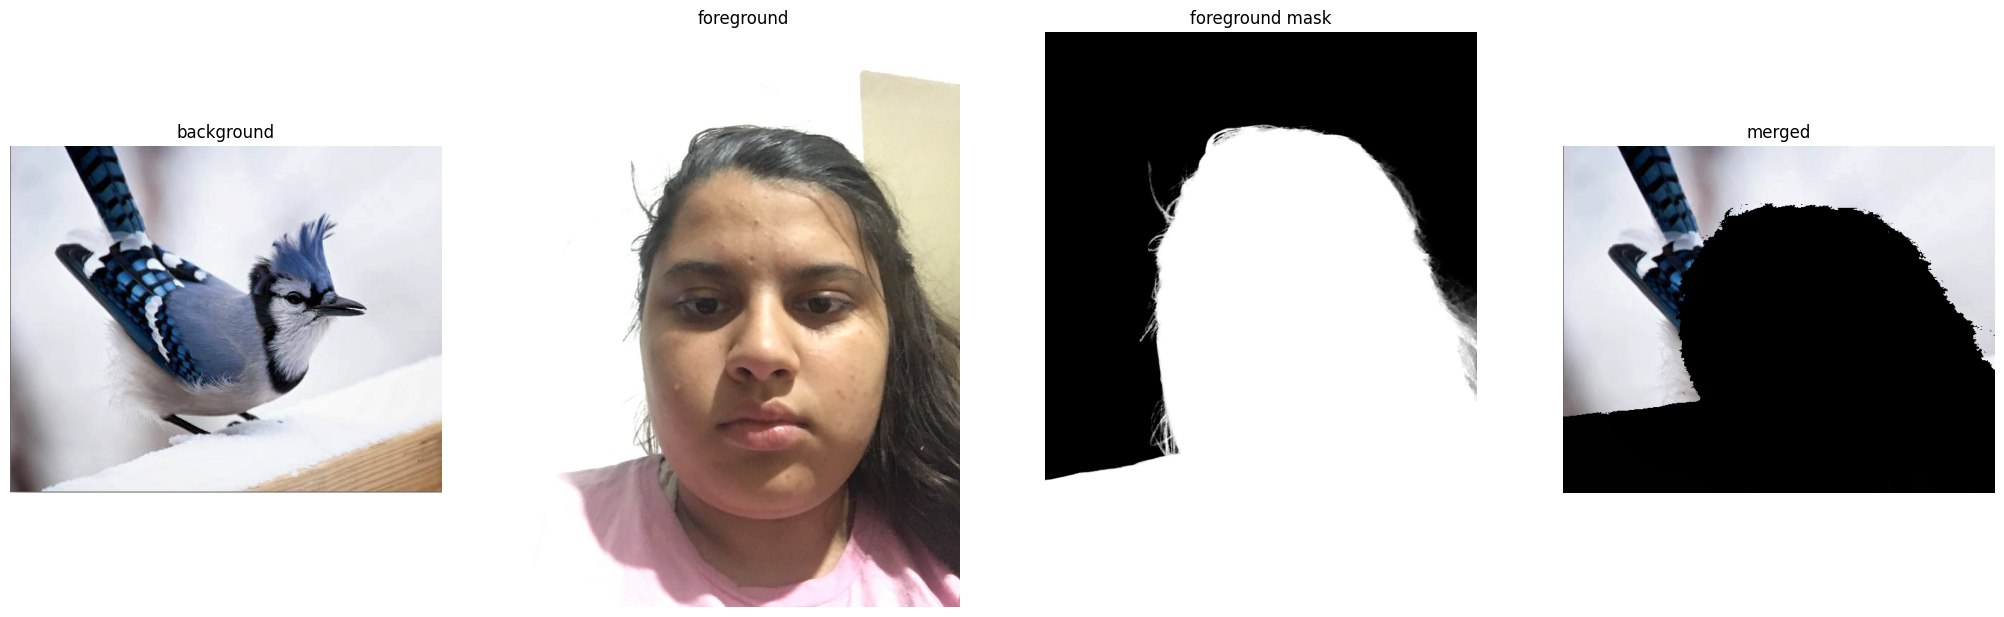

In [36]:
tulips = io.imread("./Test_Images/bird.jpg")
woman = io.imread("./Test_Images/test_objects/images/000003_4_000003_FEMALE_22.jpg")
woman_mask = io.imread("./Test_Images/test_objects/masks/000003_4_000003_FEMALE_22.png", as_gray=True)



# final = Color_Harmonization(tulips,woman, woman_mask, method=CH.NOTHING).harmonize()
final1 = Color_Harmonization(tulips,woman, woman_mask, method=CH.BRIGHTNESS_WHOLE).harmonize()
show_images([tulips, woman, woman_mask, final1], ["background", "foreground", "foreground mask", "merged"])
# final2 = Color_Harmonization(tulips,woman, woman_mask, method=CH.BRIGHTNESS_OBJ).harmonize()
# show_images([final, final1, final2],["original","Harmonization 1","Harmonization 2"])

## Merge Images

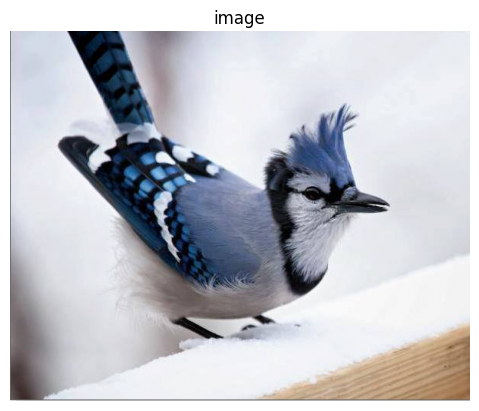

In [37]:
tulips_hsv = skimage.color.rgb2hsv(tulips)

tulips_h = tulips_hsv[:,:,0]
show_images([skimage.color.hsv2rgb(tulips_hsv)],["image"])

# bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')


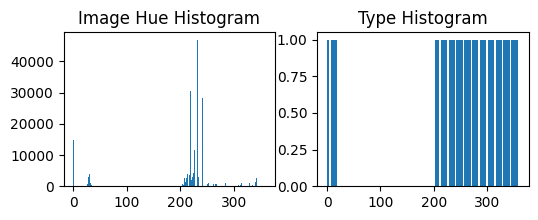

(<Hue_Type.T: 5>, 112)


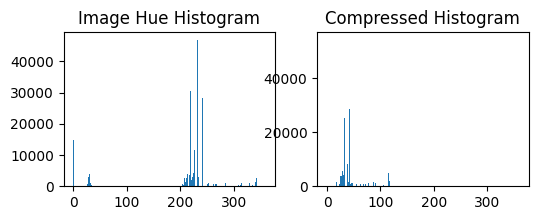

In [53]:
class Hue_Type(Enum):
    i = 1
    V = 2
    L = 3
    I = 4
    T = 5
    Y = 6
    X = 7
class Calc_Type():
    types = {
        Hue_Type.i: [(260, 280)],
        Hue_Type.V: [(225, 315)],
        Hue_Type.L: [(260, 280), (320, 359), (0,40)],
        Hue_Type.I: [(260, 280), (80,100)],
        Hue_Type.T: [(90, 270)],
        Hue_Type.Y: [(225, 315), (80, 100)],
        Hue_Type.X: [(225, 315), (45, 135)],
    }
    split_types = {
        Hue_Type.L: [(150,300), (300, 360), (0, 150)],
        Hue_Type.I: [(260, 280), (80,100)],
        Hue_Type.I: [(260, 280), (80,100)],
        Hue_Type.Y: [(225, 315), (80, 100)],
        Hue_Type.X: [(225, 315), (45, 135)],
    }
    type_edges = {
        Hue_Type.i: [260, 280],
        Hue_Type.V: [225, 315],
        Hue_Type.L: [260, 280, 320, 40],
        Hue_Type.I: [260, 280, 80,100],
        Hue_Type.T: [90, 270],
        Hue_Type.Y: [225, 315, 80, 100],
        Hue_Type.X: [225, 315, 45, 135],
    }
    types_mat = None
    
    def get_hue_hist(self):
        self.histogram = histogram(self.img_hue, nbins=360)[0]


    def hue_distance(hue, edges):
        values = [min(abs(hue - edge), abs(360 - hue + edge)) for edge in edges]
        return min(values)


    def calc_matrices():
        Calc_Type.types_mat = {}
        for key, value in Calc_Type.types.items():
            Calc_Type.types_mat[key] = np.zeros(360)
            for i in value:
                Calc_Type.types_mat[key][i[0]:i[1]] = 1
        
    def __init__(self, img_hue):
        if Calc_Type.types_mat is None:
            Calc_Type.calc_matrices()
        self.img_hue = img_hue
        self.get_hue_hist()
        self.num_pixels = np.sum(self.histogram)
        self.type = self.get_type()

    def get_type(self):
        max_dist = None
        max_type = None
        for key, value in Calc_Type.types_mat.items():
            for i in range(0, 360, 1):
                edges = [(edge + i) % 360 for edge in Calc_Type.type_edges[key]]
                hist = self.histogram * (1- np.roll(value, i))
                dist = np.sum([
                    Calc_Type.hue_distance(idx, edges)*h for idx, h in enumerate(hist)
                ])

                if not max_dist or (max_dist - dist) >  self.num_pixels * 360 * 0.001:
                    max_dist = dist
                    max_type = key, i

        return max_type

    def draw_hist(self):
        fig = plt.figure()
        fig.add_subplot(1, 2, 1).set_title("Image Hue Histogram")
        bar(range(360), self.histogram, width=0.8, align='center')
        fig.add_subplot(1, 2, 2).set_title("Type Histogram")
        bar(range(360), np.roll(Calc_Type.types_mat[self.type[0]], self.type[1]), width=0.8, align='center')
        fig.set_size_inches(6, 2)
        plt.show()

        return self.type

    
    def harmonize(self):
        if Calc_Type.split_types.get(self.type[0]):
            return self.harmonize_split()
        else:
            return self.harmonize_whole()
        
    def harmonize_whole(self):
        lower_bound, upper_bound = Calc_Type.types[self.type[0]][0]
        

        # Define the desired range for compression (e.g., 0-360 degrees)
        full_range = 360  # Full range of hues

        # Calculate the shift required to compress the range between 120-200 degrees
        shift = lower_bound + self.type[1]

        # Calculate the scaling factor to fit the desired range (120-200 degrees) within the full range (0-360 degrees)
        scaling_factor = (upper_bound - lower_bound) / full_range

        mapping = {}
        # Perform the hue compression by shifting and scaling the histogram values
        compressed_histogram = np.zeros_like(self.histogram)
        for i in range(len(self.histogram)):
            # Shift the hue values
            new_index = (i + shift) % full_range
            
            # Scale the shifted values to fit within the desired range
            new_index = int(new_index * scaling_factor)
            
            # Assign the histogram value to the new index
            compressed_histogram[new_index] += self.histogram[i]

            mapping[i] = new_index

        # Plot the compressed histogram
        fig = plt.figure()
        fig.add_subplot(1, 2, 1).set_title("Image Hue Histogram")
        bar(range(360), self.histogram, width=0.8, align='center')
        fig.add_subplot(1, 2, 2).set_title("Compressed Histogram")
        bar(range(360), compressed_histogram, width=0.8, align='center')
        fig.set_size_inches(6, 2)
        plt.show()


        # Apply the histogram mapping to the hue channel
        harmonized = np.vectorize(mapping.get)(self.img_hue)
        return harmonized
        

my_type = Calc_Type(tulips_h)
print(my_type.draw_hist())
my_type.harmonize()